In [2]:
import implicit
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import csv 
import scipy
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from implicit.nearest_neighbours import bm25_weight
from implicit import alternating_least_squares
import umap

In [224]:
data = []
with open('interactions_30_ch_no_bots') as csvfile:
    datareader = csv.reader(csvfile, delimiter=' ')
    for subreddit, user, comments, _ in datareader:
        data.append([user, subreddit, int(comments)])

In [225]:
data = pd.DataFrame.from_records(data)

In [226]:
data.columns = ['user', 'subreddit', 'comments']

In [227]:
data['user'] = data['user'].astype("category")
data['subreddit'] = data['subreddit'].astype("category")

In [228]:
# create a sparse matrix of all the artist/user/play triples
comments = coo_matrix((data['comments'].astype(float), 
                   (data['subreddit'].cat.codes, 
                    data['user'].cat.codes)))

### Latent Semantic Analysis

In [8]:
# toggle this variable if you want to recalculate the als factors
read_als_factors_from_file = True

In [9]:
if read_als_factors_from_file:
    subreddit_factors = np.load('subreddit_factors_als.npy')
    user_factors = np.load('user_factors_als.npy')
else:
    subreddit_factors, user_factors = alternating_least_squares(bm25_weight(comments), 20)

In [65]:
subreddit_factors, user_factors = alternating_least_squares(bm25_weight(comments), 20)

100%|██████████| 15.0/15 [00:56<00:00,  3.66s/it]


In [10]:
class TopRelated(object):
    def __init__(self, subreddit_factors):
        norms = np.linalg.norm(subreddit_factors, axis=-1)
        self.factors = subreddit_factors / norms[:, np.newaxis]
        self.subreddits = data['subreddit'].cat.categories.array.to_numpy()

    def get_related(self, subreddit, N=10):
        subredditid = np.where(self.subreddits == subreddit)[0][0]
        scores = self.factors.dot(self.factors[subredditid])
        best = np.argpartition(scores, -N)[-N:]
        best_ = [self.subreddits[i] for i in best]
        return sorted(zip(best_, scores[best]), key=lambda x: -x[1])

In [11]:
top_related = TopRelated(subreddit_factors)

In [12]:
top_related.get_related('OnePiece')

[('OnePiece', 0.99999994),
 ('Naruto', 0.99061096),
 ('bleach', 0.98533773),
 ('OnePunchMan', 0.98216236),
 ('gamingadvice', 0.9787289),
 ('KillLaKill', 0.9785078),
 ('animebazaar', 0.97804713),
 ('StardustCrusaders', 0.9744566),
 ('snowleopards', 0.97381645),
 ('RolledTheDice', 0.97334623)]

In [13]:
subreddit_factors.shape

(41143, 20)

In [14]:
subreddits_embedded = umap.UMAP().fit_transform(subreddit_factors)
subreddits_embedded.shape

(41143, 2)

In [15]:
subreddits_embedded

array([[ 3.4981177, -2.786402 ],
       [ 4.1943135,  5.09649  ],
       [ 4.831988 ,  1.9612825],
       ...,
       [ 2.7854004,  6.819096 ],
       [-1.8735471, -3.6882179],
       [ 5.0341783,  3.1146567]], dtype=float32)

In [16]:
subreddits = data['subreddit'].cat.categories.array.to_numpy()

In [17]:
import random

indices = random.sample(range(len(subreddits)), 1000)

In [18]:
sampled_subreddits = subreddits[indices]
sampled_subreddits_embedded = subreddits_embedded[indices]

In [19]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='abkds', api_key='KKuXHMUKu7EHg9kIZWrl')


# Create random data with numpy
import numpy as np

N = 500
xs = sampled_subreddits_embedded[:, 0]
ys = sampled_subreddits_embedded[:, 1]

# Create a trace
trace = go.Scatter(
    x = xs,
    y = ys,
    mode='markers+text',
    text=sampled_subreddits
)

data_ = [trace]

# Plot and embed in ipython notebook!
py.iplot(data_, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~abkds/0 or inside your plot.ly account where it is named 'basic-scatter'


### Bayesian Personalized Ranking

In [20]:
from implicit.bpr import BayesianPersonalizedRanking

params = {"factors": 63}

In [21]:
import logging
import tqdm
import time
import codecs

In [22]:
model = BayesianPersonalizedRanking(**params)

In [23]:
model_name = 'bpr'
output_filename = 'subreddits_recs_bpr'

In [24]:
model.fit(comments)

100%|██████████| 100/100 [03:57<00:00,  2.68s/it, correct=95.88%, skipped=7.16%]


In [25]:
def bpr_related_subreddits(subreddit):
    found = np.where(subreddits == subreddit)
    if len(found[0]) == 0:
        raise ValueError("Subreddit doesn't exist in the dataset.")
    _id = found[0][0]
    return [(subreddits[i], v) for i, v in model.similar_items(_id)]

In [26]:
bpr_related_subreddits('dogs')

[('dogs', 2.9314072),
 ('Dogtraining', 2.7764423),
 ('puppy101', 2.6298523),
 ('Pets', 2.5438745),
 ('AskVet', 2.5281637),
 ('rescuedogs', 2.4704523),
 ('WiggleButts', 2.4026453),
 ('DoggyDNA', 2.3814583),
 ('mutt', 2.3722208),
 ('schnauzers', 2.3701365)]

In [27]:
users = data['user'].cat.categories.array.to_numpy()

In [28]:
write_bpr_recommendations = False

In [32]:
user_comments = comments.T.tocsr()
if write_bpr_recommendations:
    # generate recommendations for each user and write out to a file
    with tqdm.tqdm_notebook(total=len(users)) as progress:
        with codecs.open(output_filename, "w", "utf8") as o:
            for userid, username in enumerate(users):
                for subredditid, score in model.recommend(userid, user_comments):
                    o.write("%s\t%s\t%s\n" % (username, subreddits[subredditid], score))
                progress.update(1)

### Sample user recommendations

We went through the user 'xkcd_transciber' list of subreddits, where he/she commented. Taking a view of the kind of subreddits followed by the user we see that the predictions are good. This is just one sample, we are saving the recommendations for all users in a file and will also write the AUC score function for getting the exact scores for the generated recommendations.

In [33]:
def recommend_for_user(username):
    sample_user_id = np.where(users == username)[0][0]
    return [(subreddits[i], v) for i, v in model.recommend(2293528, user_comments)]

In [34]:
recommend_for_user('xkcd_transcriber')

[('programmingcirclejerk', 3.6349902),
 ('CivCringe', 3.4902062),
 ('LinuxCirclejerk', 3.413476),
 ('cataclysmdda', 3.3854566),
 ('roguelikedev', 3.3806605),
 ('spam', 3.3729367),
 ('AutoModerator', 3.3288083),
 ('modclub', 3.3230174),
 ('unfilter', 3.2809386),
 ('Cyberpunk_Music', 3.2804885)]

In [37]:
def subreddits_interacted_by_user(username):
    sample_user_id = np.where(users == username)[0][0]
    _idlist =  comments.getcol(sample_user_id)
    return [subreddits[idx] for idx, i in enumerate(_idlist.toarray()) if i != 0.0]

In [38]:
# sample 50 reddits with which xkcd_transcriber has interacted with.
random.sample(subreddits_interacted_by_user('xkcd_transcriber'), 50)

['Austin',
 'BlackPeopleTwitter',
 'videos',
 'Planetside',
 'roosterteeth',
 'mistyfront',
 'oculus',
 'TrollXGirlGamers',
 'DIY',
 'speedrun',
 'houston',
 'wow',
 'chadev',
 'skyrim',
 'AskFeminists',
 'brasil',
 'firefly',
 'asktransgender',
 'Ubuntu',
 'clickbaitEd',
 'ANormalDayInRussia',
 'gamedev',
 'FloridaMan',
 'javascript',
 'rva',
 'sex',
 'CasualConversation',
 'moraldilemmas',
 'me_irl',
 'NoStupidQuestions',
 'trackers',
 'NoFap',
 'ynab',
 'Multicopter',
 'ProtectAndServe',
 'geography',
 'sciencefiction',
 'rccars',
 'InternetIsBeautiful',
 'arabs',
 'Frozen',
 'economy',
 'crypto',
 'techsupportgore',
 'latterdaysaints',
 'lgbt',
 'asoiaf',
 'collapse',
 'makeyourchoice',
 'ar15']

In [355]:
# set seed to get the same train and test set
np.random.seed(42)

filename = 'interactions_30_ch_no_bots'
train_filename = 'interactions_5'

def create_dataset():
    data = defaultdict(lambda: [])
    with open(filename) as csvfile:
        datareader = csv.reader(csvfile, delimiter=' ')        
        for subreddit, user, comments, _ in tqdm.tqdm_notebook(datareader):
            data[user].append((subreddit, comments))
    

    f_train = open(train_filename, 'a')
    
    for user, items in tqdm.tqdm_notebook(data.items()):
        np.random.shuffle(items)
        if len(items) >= 5:
            for item in items:
                line = ' '.join(list(map(str, [item[0], user, item[1]]))) + '\n'
                f_train.write(line)
    
    f_train.close()
        
create_dataset()

In [356]:
data = []
with open('interactions_5') as csvfile:
    datareader = csv.reader(csvfile, delimiter=' ')
    for subreddit, user, comments in datareader:
        data.append([user, subreddit, int(comments)])

In [357]:
data = pd.DataFrame.from_records(data)
data.columns = ['user', 'subreddit', 'comments']

data['user'] = data['user'].astype("category")
data['subreddit'] = data['subreddit'].astype("category")

In [358]:
# create a sparse matrix of all the artist/user/play triples
comments = coo_matrix((data['comments'].astype(float), 
                   (data['subreddit'].cat.codes, 
                    data['user'].cat.codes)))

In [359]:
comments

<35276x517371 sparse matrix of type '<class 'numpy.float64'>'
	with 5731059 stored elements in COOrdinate format>

In [360]:
subreddits = data['subreddit'].cat.categories.array.to_numpy()
users = data['user'].cat.categories.array.to_numpy()

In [361]:
print('Number of users for BPR model: %s' % len(users))
print('Number of subreddits for BPR model: %s' % len(subreddits))

Number of users for BPR model: 517371
Number of subreddits for BPR model: 35276


Create the index and the reverse index for the users and subreddits

In [362]:
def item_to_index(things):
    index = {}
    for idx, item in enumerate(things):
        index[item] = idx
    return index

def index_to_item(index):
    things = np.empty(len(index), dtype=object)
    for item, idx in index.items():
        things[idx] = item
    return things

In [363]:
subreddits_index = item_to_index(subreddits)
users_index = item_to_index(users)

### Extracting test set

We will pluck out the test set, as per the strategy given in the paper [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/pdf/1205.2618.pdf), section 6.2 

In [364]:
def train_test_split(coo_comments):
    """
    Omits random user subreddit interactions, zeros them out 
    and appends them to the test list.
    """
    csr_comments = coo_comments.tocsr()
    
    data = defaultdict(lambda: [])
    with open('interactions_5') as csvfile:
        datareader = csv.reader(csvfile, delimiter=' ')        
        for subreddit, user, comments in tqdm.tqdm_notebook(datareader):
            data[user].append((subreddit, comments))
    
    train_set = []
    test_set = []
    
    for user, items in tqdm.tqdm_notebook(data.items()):
        np.random.shuffle(items)
        test_item = items[0]
        test_comments = items[1]
        
        test_subreddit = test_item[0]
        # zero out a user item interaction
        csr_comments[subreddits_index[test_subreddit], users_index[user]] = 0
        
        test_set.append([test_subreddit, user, int(comments)])
        
        for item in items[1:]:
            train_set.append([item[0], user, int(item[1])])
        
    csr_comments.eliminate_zeros()
    return train_set, test_set, csr_comments.tocoo()

In [365]:
train_set, test_set, comments = train_test_split(comments)

### AUC Metric

We will implement the AUC Metric for evaluation of BPR based methods. We take the definition given in the paper [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/pdf/1205.2618.pdf), section 6.2 . AUC is defined as 
 
$$AUC = \frac{1}{| U |} \sum_u \frac{1}{|E(u)|} \sum_{(i, j) \in E(u)} \delta(\hat{x}_{ui} - \hat{x}_{xj}) $$

where $$E(u) := \{(i, j) | (u, i) \in S_{test} ∧ (u, j) \notin (S_{test} ∪ S_{train})\}$$



In [366]:
# create E(u) list for each user and store it use ids instead of names to store them
E_u = defaultdict(lambda : set())

for subreddit, user, _ in tqdm.tqdm_notebook(train_set):
        E_u[users_index[user]].add(subreddits_index[subreddit])
            
for subreddit, user, _ in tqdm.tqdm_notebook(test_set):
        E_u[users_index[user]].add(subreddits_index[subreddit])

In [367]:
# train the bpr model 
from implicit.bpr import BayesianPersonalizedRanking

params = {"factors": 63}

In [368]:
model = BayesianPersonalizedRanking(**params)

In [369]:
comments

<35276x517371 sparse matrix of type '<class 'numpy.float64'>'
	with 5213688 stored elements in COOrdinate format>

In [370]:
model.fit(comments)

100%|██████████| 100/100 [03:18<00:00,  1.29s/it, correct=94.68%, skipped=9.65%]


In [375]:
num_subreddits = len(subreddits)

In [376]:
def auc(test_set, user_factors, subreddit_factors, subreddits, users):
    """
    Returns the auc score on a test data set
    """
    num_users = len(test_set)
    
    total = 0
    
    # treat the signal as 1 as per the implicit bpr paper
    for subreddit, user, signal in tqdm.tqdm_notebook(test_set):  # outer summation
        # inner summation 
        # TODO: try to parallelize 
        u = users_index[user]
        i = subreddits_index[subreddit]
        
        x_ui = user_factors[u].dot(subreddit_factors[i])
        
        js = []
        
        for j in range(0, num_subreddits):
            if j != i and j not in E_u[u]:
                js.append(j)
                
        total += np.sum(np.heaviside(x_ui - user_factors[u].dot(subreddit_factors[js].T), 0)) / len(js)
            
        # for j in range(0, subreddits):
        #    numel = 0
        #    total_user = 0
        #    if j != i and j not in E_u[u]:
        #        numel += 1
        #        x_uj = user_factors[u].dot(subreddit_factors[j])
        #            total_user += heaviside(x_ui - x_uj)
        
        # total += (total_user * 1.0 / numel)
    
    return total / num_users

In [380]:
auc(test_set[:10000], model.user_factors, model.item_factors, subreddits, users)

0.792281380304895

In [382]:
def get_aucs_vs_factors():
    factors = [8, 16, 32, 64, 128]
    params_list = [{"factors": factor} for factor in factors]
    
    aucs = []
    
    for params in params_list:
        model = BayesianPersonalizedRanking(**params)
        model.fit(comments)
        aucs.append(auc(test_set[:10000], model.user_factors, model.item_factors, subreddits, users))
    
    return aucs

In [383]:
aucs_vs_factors = get_aucs_vs_factors()

100%|██████████| 100/100 [01:28<00:00,  1.16it/s, correct=87.39%, skipped=9.65%]


100%|██████████| 100/100 [01:30<00:00,  1.13it/s, correct=91.95%, skipped=9.65%]


100%|██████████| 100/100 [02:10<00:00,  1.09s/it, correct=94.13%, skipped=9.65%]


100%|██████████| 100/100 [02:26<00:00,  1.32s/it, correct=94.62%, skipped=9.64%]


100%|██████████| 100/100 [05:03<00:00,  3.14s/it, correct=94.52%, skipped=9.64%]


In [384]:
aucs_vs_factors

[0.798349415153003,
 0.7943562578985813,
 0.7908248719162625,
 0.7917815922414179,
 0.7885166293608563]

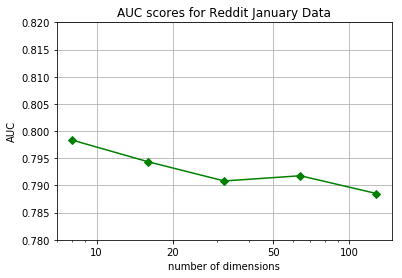

In [421]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


xs = np.array([8, 16, 32, 64, 128])
ys = aucs_vs_factors
axes = plt.axes()
plt.semilogx(xs, ys, '-gD')
axes.set_ylim([0.78, .82])
axes.set_xticks([10, 20, 50, 100])
axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes.set_xlabel('number of dimensions')
axes.set_ylabel('AUC')
plt.title('AUC scores for Reddit January Data')
plt.grid()
plt.show()